# Training models with ai4i2020 dataset
- pre processing the dataset
    - load train data file and test data file(modified by FordA_visualization.ipynb)
    - split train data and validation data (80: 20)
    - normalize the data, reshape the data

- train models and store the best model
    - CNN
    - RNN
    - LSTM
    - GRU

In [ ]:
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

## Load data file
- mount to Google drive
- load modified data from the drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My\ Drive/Colab\ Notebooks/summer_coop/FordA

/content/drive/My Drive/Colab Notebooks/summer_coop/FordA


In [ ]:
ls

ai4i2020_result.png                       FordA_result.tsv
best_cnn_model.h5                         FordA_test_modified.npy
best_gru_model.h5                         FordA_TEST.tsv
best_lstm_model.h5                        FordA_TRAIN.tsv
best_rnn_model.h5                         FordA_visualization.ipynb
cnn_architecture.png                      gru_architecture.png
FordA_Correlation_bw_failure_sensors.png  lstm_architecture.png
FordA_modified.npy                        rnn-architecture.png
FordA_result.gsheet                       xgboost_result.png


In [ ]:
data_arr = np.load('./FordA_modified.npy')
data_arr[:10, 0]

array([1., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

### split features and class
- feuture: 500 sensors' value (col 1 ~ 500)
- class: machine failure (col 0)
    - 0: normal situation
    - 1: failure situation

In [ ]:
train_target = data_arr[:, 0]
train_input = data_arr[:, 1:]
print(train_target.shape, train_input.shape)

(3601,) (3601, 500)


## Normalize the data

In [ ]:
mean = train_input.mean()
std = train_input.std()
train_scaled = (train_input - mean) / std

## Reshape the data
- keras CNN, RNN needs 3 dim inputs
    - (3601, 500) -> (3601, 500, 1)

In [ ]:
train_scaled = train_scaled.reshape(-1, 500, 1)

## Split train data and validation data
- train: validation = 80: 20

In [ ]:

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, stratify = train_target, test_size = 0.2)
print(train_scaled.shape, val_scaled.shape, train_target.shape, val_target.shape)

(2880, 500, 1) (721, 500, 1) (2880,) (721,)


## Training model
- binary classification
- supervised training

### CNN

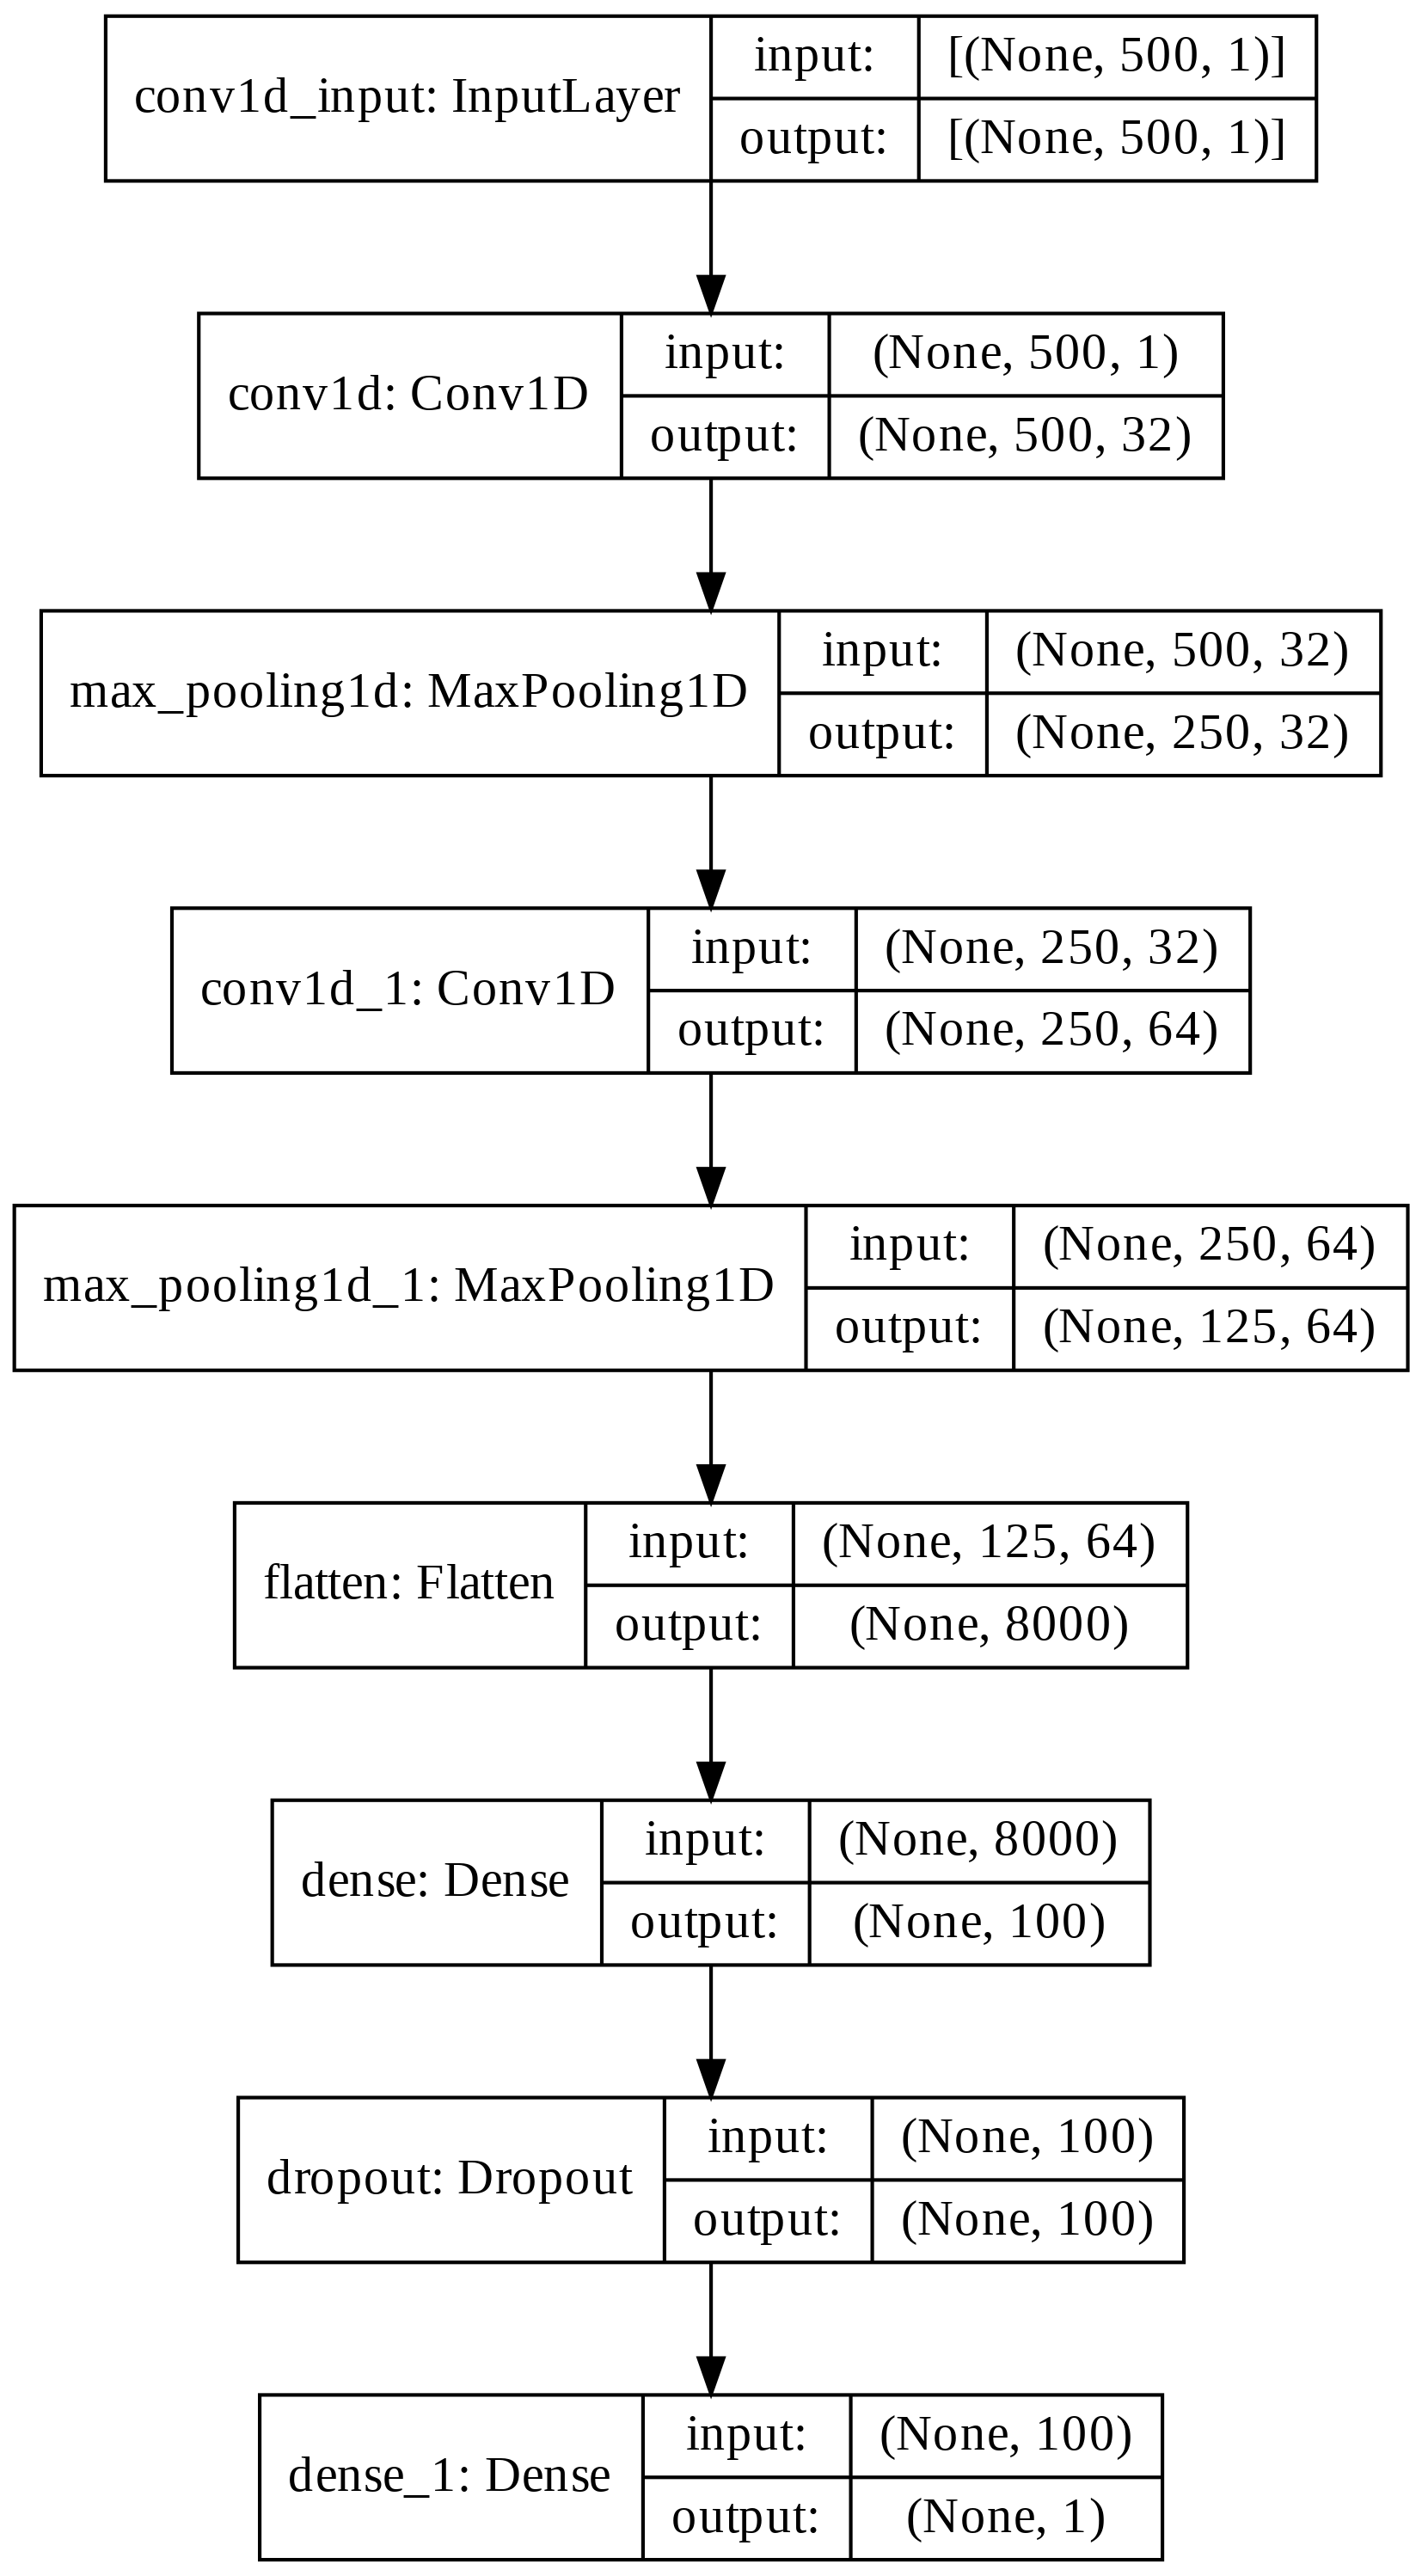

In [ ]:
cnn = keras.Sequential()
cnn.add(keras.layers.Conv1D(32, kernel_size=2, padding = 'same', activation = 'relu', input_shape = (500, 1)))
cnn.add(keras.layers.MaxPooling1D(2))
cnn.add(keras.layers.Conv1D(64, kernel_size=2, padding = 'same', activation = 'relu'))
cnn.add(keras.layers.MaxPooling1D(2))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(100, activation = 'relu'))
cnn.add(keras.layers.Dropout(0.4))
cnn.add(keras.layers.Dense(1, activation = 'sigmoid'))
keras.utils.plot_model(cnn, to_file = './cnn_architecture.png', show_shapes = True, dpi = 300)


In [ ]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_cnn_model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights=True)
cnn_history = cnn.fit(train_scaled, train_target, epochs = 100, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/100
90/90 [==============================] - 4s 34ms/step - loss: 0.6933 - accuracy: 0.5299 - val_loss: 0.6778 - val_accuracy: 0.5964
Epoch 2/100
90/90 [==============================] - 3s 32ms/step - loss: 0.6082 - accuracy: 0.6573 - val_loss: 0.5354 - val_accuracy: 0.7393
Epoch 3/100
90/90 [==============================] - 3s 32ms/step - loss: 0.4951 - accuracy: 0.7625 - val_loss: 0.4409 - val_accuracy: 0.8280
Epoch 4/100
90/90 [==============================] - 3s 32ms/step - loss: 0.4341 - accuracy: 0.7889 - val_loss: 0.4091 - val_accuracy: 0.8294
Epoch 5/100
90/90 [==============================] - 3s 32ms/step - loss: 0.3594 - accuracy: 0.8462 - val_loss: 0.3555 - val_accuracy: 0.8350
Epoch 6/100
90/90 [==============================] - 3s 32ms/step - loss: 0.3032 - accuracy: 0.8694 - val_loss: 0.3083 - val_accuracy: 0.8613
Epoch 7/100
90/90 [==============================] - 3s 32ms/step - loss: 0.2853 - accuracy: 0.8757 - val_loss: 0.3363 - val_accuracy: 0.8530
Epoch 

### RNN

In [ ]:
rnn = keras.Sequential()
rnn.add(keras.layers.SimpleRNN(10, input_shape = (500,1)))
rnn.add(keras.layers.Dense(1, activation = 'sigmoid'))
keras.utils.plot_model(rnn, show_shapes = True, dpi = 300, to_file = './rnn_architecture.png')
rms = keras.optimizers.RMSprop(learning_rate = 1e-4)


In [ ]:
rnn.compile(optimizer = rms, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_rnn_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
rnn_history = rnn.fit(train_scaled, train_target, epochs = 100, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
90/90 [==============================] - 6s 62ms/step - loss: 0.6992 - accuracy: 0.4885 - val_loss: 0.6934 - val_accuracy: 0.5104
Epoch 2/100
90/90 [==============================] - 5s 59ms/step - loss: 0.6981 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5160
Epoch 3/100
90/90 [==============================] - 5s 59ms/step - loss: 0.6974 - accuracy: 0.4976 - val_loss: 0.6928 - val_accuracy: 0.5132
Epoch 4/100
90/90 [==============================] - 5s 60ms/step - loss: 0.6968 - accuracy: 0.4997 - val_loss: 0.6927 - val_accuracy: 0.5076
Epoch 5/100
90/90 [==============================] - 5s 60ms/step - loss: 0.6963 - accuracy: 0.5010 - val_loss: 0.6926 - val_accuracy: 0.5062
Epoch 6/100
90/90 [==============================] - 6s 62ms/step - loss: 0.6960 - accuracy: 0.5052 - val_loss: 0.6926 - val_accuracy: 0.5062
Epoch 7/100
90/90 [==============================] - 5s 61ms/step - loss: 0.6957 - accuracy: 0.5056 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 

### LSTM

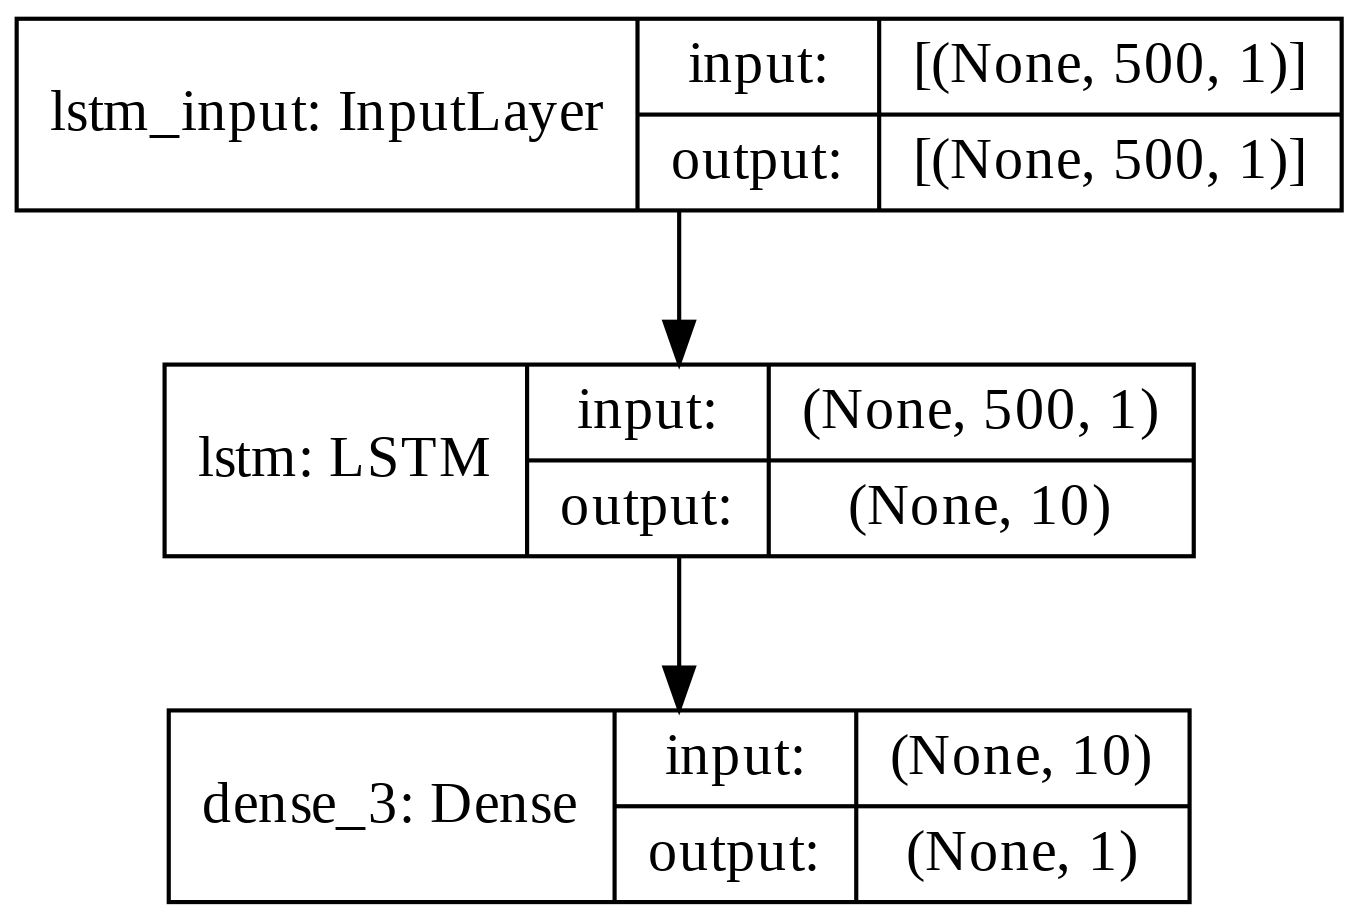

In [ ]:
lstm = keras.Sequential()
lstm.add(keras.layers.LSTM(10, input_shape=(500, 1)))
lstm.add(keras.layers.Dense(1, activation = 'sigmoid'))
keras.utils.plot_model(lstm, to_file = './lstm_architecture.png', show_shapes = True, dpi = 300)

In [ ]:
rms = keras.optimizers.RMSprop(learning_rate = 1e-4)
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_lstm_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)
lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
lstm_history = lstm.fit(train_scaled, train_target, epochs = 100, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
90/90 [==============================] - 10s 96ms/step - loss: 0.6955 - accuracy: 0.5052 - val_loss: 0.6961 - val_accuracy: 0.5021
Epoch 2/100
90/90 [==============================] - 8s 91ms/step - loss: 0.6934 - accuracy: 0.5135 - val_loss: 0.6944 - val_accuracy: 0.5368
Epoch 3/100
90/90 [==============================] - 8s 93ms/step - loss: 0.6930 - accuracy: 0.5163 - val_loss: 0.6936 - val_accuracy: 0.5201
Epoch 4/100
90/90 [==============================] - 8s 93ms/step - loss: 0.6927 - accuracy: 0.5201 - val_loss: 0.6932 - val_accuracy: 0.5132
Epoch 5/100
90/90 [==============================] - 8s 92ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6931 - val_accuracy: 0.5160
Epoch 6/100
90/90 [==============================] - 8s 93ms/step - loss: 0.6924 - accuracy: 0.5125 - val_loss: 0.6926 - val_accuracy: 0.5146
Epoch 7/100
90/90 [==============================] - 8s 92ms/step - loss: 0.6923 - accuracy: 0.5198 - val_loss: 0.6929 - val_accuracy: 0.5146
Epoch

### GRU

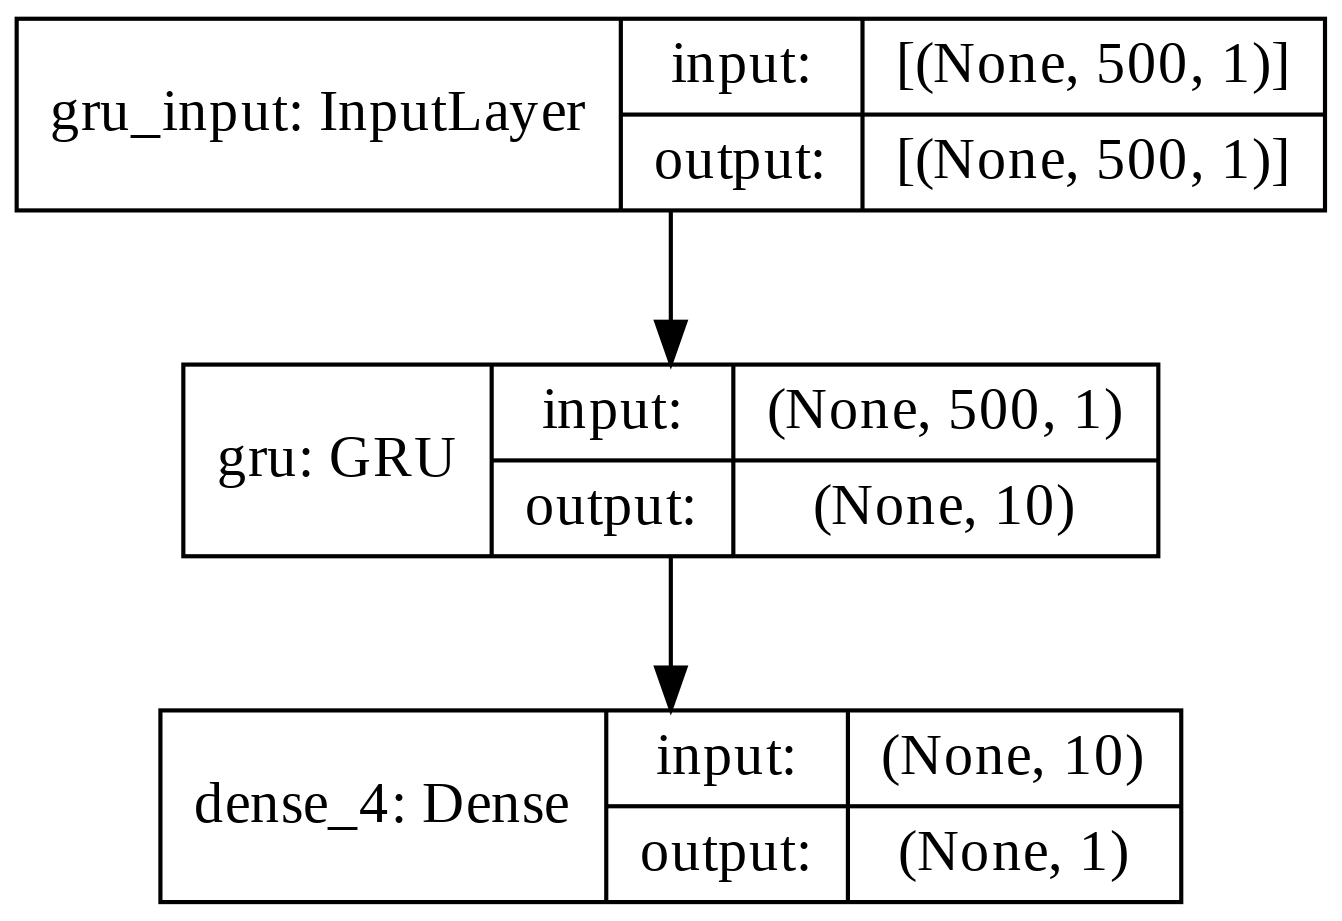

In [ ]:
gru = keras.Sequential()
gru.add(keras.layers.GRU(10, input_shape = (500, 1)))
gru.add(keras.layers.Dense(1, activation = 'sigmoid'))
keras.utils.plot_model(gru, to_file = './gru_architecture.png', show_shapes = True, dpi = 300)

In [ ]:
rms = keras.optimizers.RMSprop(learning_rate=1e-4)
gru.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_gru_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
gru_history = gru.fit(train_scaled, train_target, epochs = 100, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
90/90 [==============================] - 10s 95ms/step - loss: 0.6963 - accuracy: 0.5069 - val_loss: 0.6967 - val_accuracy: 0.4910
Epoch 2/100
90/90 [==============================] - 8s 91ms/step - loss: 0.6938 - accuracy: 0.5153 - val_loss: 0.6947 - val_accuracy: 0.5104
Epoch 3/100
90/90 [==============================] - 8s 91ms/step - loss: 0.6935 - accuracy: 0.5045 - val_loss: 0.6942 - val_accuracy: 0.5187
Epoch 4/100
90/90 [==============================] - 8s 89ms/step - loss: 0.6931 - accuracy: 0.5128 - val_loss: 0.6941 - val_accuracy: 0.5132
Epoch 5/100
90/90 [==============================] - 8s 93ms/step - loss: 0.6931 - accuracy: 0.5104 - val_loss: 0.6935 - val_accuracy: 0.4882
Epoch 6/100
90/90 [==============================] - 8s 90ms/step - loss: 0.6930 - accuracy: 0.5122 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 7/100
90/90 [==============================] - 8s 91ms/step - loss: 0.6930 - accuracy: 0.5115 - val_loss: 0.6928 - val_accuracy: 0.5118
Epoch

## Data preprocessing for machine learning

In [ ]:
data_input = data_arr[:, 1:]
data_target = data_arr[:, 0] 
print(data_input.shape, data_target.shape)

(3601, 500) (3601,)


In [ ]:
train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, test_size = 0.2, stratify = data_target)

In [ ]:
print(train_input.shape, test_input.shape)

(2880, 500) (1320, 500)


### Normalization
- normalize with train data's mean and std

In [ ]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [ ]:
print(train_scaled.shape, test_scaled.shape)

(2880, 500) (721, 500)


In [ ]:
print(train_scaled)

[[ 1.59643725  0.99953381  0.31193554 ...  0.07126849  0.72460103
   1.21561104]
 [ 0.50643394  0.43112549  0.31908968 ... -0.46292214 -0.57330202
  -0.62978533]
 [-1.60937382 -1.61459542 -1.14179802 ... -0.11340327  0.06067018
   0.23734632]
 ...
 [-0.30127923 -0.33294881 -0.2331733  ... -0.15354815 -0.11979415
  -0.09737972]
 [-1.36400079 -1.40349783 -1.30716543 ...  0.18220345  0.17439094
   0.2050069 ]
 [-0.71525559 -0.70669936 -0.783276   ...  1.78770378  1.57580615
   1.23079716]]


### Logistic Regressioin

In [ ]:
lr = LogisticRegression(max_iter = 2000)
splitter = StratifiedKFold(n_splits = 10)
lr_score = cross_validate(lr, train_scaled, train_target, cv = splitter, return_train_score= True, return_estimator= True)

In [ ]:
print(np.mean(lr_score['train_score']), np.mean(lr_score['test_score']))

0.5892746913580248 0.5128472222222221


In [ ]:
print(lr_score['estimator'])
print(lr_score['train_score'])

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LogisticRegress

### XGBoost

In [ ]:
train_scores = []
test_scores = []
for i in range(1, 20):
    xgb = XGBClassifier(max_depth = i, n_estimators = 1000)
    xgb.fit(train_scaled, train_target, eval_metric = 'error', eval_set = [(test_scaled, test_target)], early_stopping_rounds=10)
    train_scores.append(xgb.score(train_scaled, train_target))
    test_scores.append(xgb.score(test_scaled, test_target))


[0]	validation_0-error:0.506241
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.506241
[2]	validation_0-error:0.506241
[3]	validation_0-error:0.506241
[4]	validation_0-error:0.51595
[5]	validation_0-error:0.51595
[6]	validation_0-error:0.503467
[7]	validation_0-error:0.507628
[8]	validation_0-error:0.506241
[9]	validation_0-error:0.518724
[10]	validation_0-error:0.518724
[11]	validation_0-error:0.509015
[12]	validation_0-error:0.509015
[13]	validation_0-error:0.518724
[14]	validation_0-error:0.504854
[15]	validation_0-error:0.514563
[16]	validation_0-error:0.504854
Stopping. Best iteration:
[6]	validation_0-error:0.503467

[0]	validation_0-error:0.486824
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.464632
[2]	validation_0-error:0.466019
[3]	validation_0-error:0.461859
[4]	validation_0-error:0.456311
[5]	validation_0-error:0.460472
[6]	validation_0-error:0.454924
[7]	validation_0-error:0.463245
[8]	

#### Visualize the score
- finding the best max_depth
- difference betweeh train and test set score is minimum when max_depth = 8
- overfitting

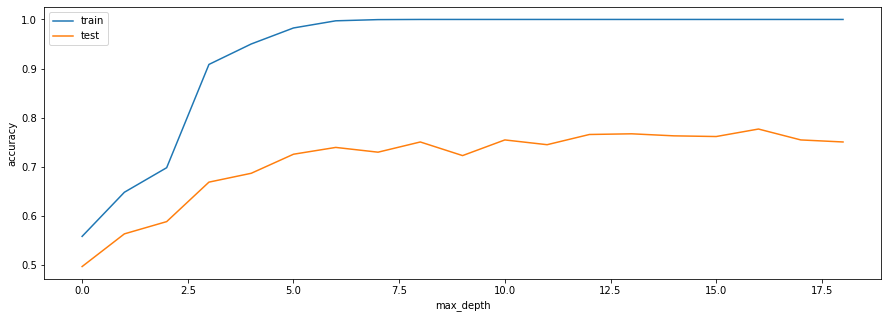

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(train_scores)
plt.plot(test_scores)
plt.legend(['train', 'test'])
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.savefig('./xgboost_result.png')
plt.show()

#### Adapt the selected max_depth

In [ ]:
xgb = XGBClassifier(max_depth=8, n_estimators=1000)
xgb.fit(train_scaled, train_target, eval_set = [(test_scaled, test_target)], early_stopping_rounds= 10, eval_metric = 'error')

[0]	validation_0-error:0.409154
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.411928
[2]	validation_0-error:0.416089
[3]	validation_0-error:0.386963
[4]	validation_0-error:0.381415
[5]	validation_0-error:0.371706
[6]	validation_0-error:0.364771
[7]	validation_0-error:0.356449
[8]	validation_0-error:0.37448
[9]	validation_0-error:0.359223
[10]	validation_0-error:0.357836
[11]	validation_0-error:0.350902
[12]	validation_0-error:0.348128
[13]	validation_0-error:0.343967
[14]	validation_0-error:0.34258
[15]	validation_0-error:0.345354
[16]	validation_0-error:0.331484
[17]	validation_0-error:0.341193
[18]	validation_0-error:0.338419
[19]	validation_0-error:0.334258
[20]	validation_0-error:0.327323
[21]	validation_0-error:0.319001
[22]	validation_0-error:0.317614
[23]	validation_0-error:0.319001
[24]	validation_0-error:0.316227
[25]	validation_0-error:0.313454
[26]	validation_0-error:0.309293
[27]	validation_0-error:0.303745
[28]	validation_0-erro

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print(xgb.score(train_scaled, train_target), xgb.score(test_scaled, test_target))

0.9996527777777777 0.7295423023578363


## Test the model

### Get test data and pre processing

In [ ]:
test_arr = np.load('./FordA_test_modified.npy')
test_input = test_arr[:, 1:]
test_target = test_arr[:, 0]
print(test_input.shape, test_target.shape)

(1320, 500) (1320,)


In [ ]:
mean = test_input.mean()
std = test_input.std()

test_scaled = (test_input - mean) / std

In [ ]:
test_scaled3 = test_scaled.reshape(-1, 500, 1)

In [ ]:
cnn_score = cnn.evaluate(test_scaled3, test_target)

42/42 [==============================] - 0s 8ms/step - loss: 0.3138 - accuracy: 0.8720


In [ ]:
rnn_score = rnn.evaluate(test_scaled3, test_target)

42/42 [==============================] - 1s 18ms/step - loss: 0.6968 - accuracy: 0.4727


In [ ]:
lstm_score = lstm.evaluate(test_scaled3, test_target)

42/42 [==============================] - 1s 28ms/step - loss: 0.6675 - accuracy: 0.5773


In [ ]:
gru_score = gru.evaluate(test_scaled3, test_target)

42/42 [==============================] - 1s 23ms/step - loss: 0.6929 - accuracy: 0.5129


## Visualize the result

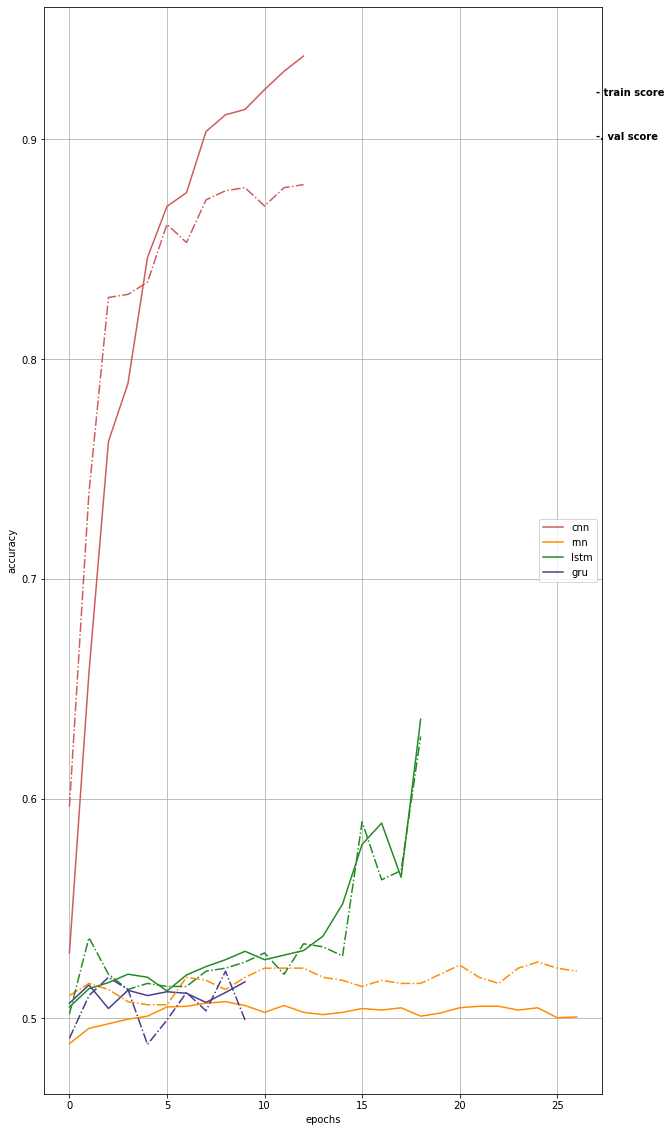

In [ ]:
plt.figure(figsize = (10, 20))
color_map = ('indianred', 'darkorange', 'forestgreen', 'darkslateblue')
plt.plot(cnn_history.history['accuracy'], color = color_map[0], label = 'cnn')
plt.plot(rnn_history.history['accuracy'], color = color_map[1], label = 'rnn')
plt.plot(lstm_history.history['accuracy'], color = color_map[2], label = 'lstm')
plt.plot(gru_history.history['accuracy'], color = color_map[3], label = 'gru')
plt.plot(cnn_history.history['val_accuracy'], color = color_map[0], linestyle = "-.")
plt.plot(rnn_history.history['val_accuracy'], color = color_map[1], linestyle = "-.")
plt.plot(lstm_history.history['val_accuracy'], color = color_map[2], linestyle = "-.")
plt.plot(gru_history.history['val_accuracy'], color = color_map[3], linestyle = "-.")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.text(27, 0.92, '- train score', fontweight = 'bold')
plt.text(27, 0.90, '-. val score', fontweight = 'bold')
plt.legend(loc = 'center right')
plt.savefig('./FordA_result.png')
plt.grid(True)
plt.show()

In [ ]:
print('\tCNN \t RNN \t LSTM \t GRU')
print('train:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f} '.format(statistics.mean(cnn_history.history['accuracy']), statistics.mean(rnn_history.history['accuracy']), statistics.mean(lstm_history.history['accuracy']), statistics.mean(gru_history.history['accuracy'])))
print('val:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f} '.format(statistics.mean(cnn_history.history['val_accuracy']), statistics.mean(rnn_history.history['val_accuracy']), statistics.mean(lstm_history.history['val_accuracy']), statistics.mean(gru_history.history['val_accuracy'])))

	CNN 	 RNN 	 LSTM 	 GRU
train:	0.835	0.503	0.539	0.511 
val:	0.830	0.517	0.536	0.506 


In [ ]:
infile = open('FordA_result.tsv', 'w')
infile.write('\tCNN \t RNN \t LSTM \t GRU \t Logistic Regression \t XGBoost\n')
infile.write('train:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(statistics.mean(cnn_history.history['accuracy']), statistics.mean(rnn_history.history['accuracy']), statistics.mean(lstm_history.history['accuracy']), statistics.mean(gru_history.history['accuracy']), np.mean(lr_score['train_score']), xgb.score(train_scaled, train_target)))
infile.write('val:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(statistics.mean(cnn_history.history['val_accuracy']), statistics.mean(rnn_history.history['val_accuracy']), statistics.mean(lstm_history.history['val_accuracy']), statistics.mean(gru_history.history['val_accuracy']), np.mean(lr_score['test_score']), xgb.score(test_scaled, test_target)))
infile.write('test:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(cnn_score[1], rnn_score[1], lstm_score[1], gru_score[1]))

infile.close()